In [1]:
import sys
import random
import math
import cv2
import json
from imgaug import augmenters as iaa
from tqdm import tqdm
import glob
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight

from PIL import Image
from sklearn.model_selection import train_test_split

import warnings 
warnings.filterwarnings("ignore")

In [2]:
DATA_DIR = '/data1/gaoxi/yh/KaggleShip/DataSet_Kaggle'

# Directory to save logs and trained model
ROOT_DIR = '/data1/gaoxi/yh/KaggleShip/Mask_RCNN'


# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [3]:
train_dicom_dir = os.path.join(DATA_DIR, 'train_v2')
test_dicom_dir = os.path.join(DATA_DIR, 'test_v2')
# val_dicom_dir = os.path.join(DATA_DIR, 'val_v2')

In [4]:
debug = False

In [5]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):    
    # Give the configuration a recognizable name  
    NAME = 'airbus'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background and ship classes
    
    IMAGE_MIN_DIM = 768
    IMAGE_MAX_DIM = 768
#     IMAGE_MIN_DIM = 384
#     IMAGE_MAX_DIM = 384
    RPN_ANCHOR_SCALES =  (16, 32, 64, 128, 256)
#     RPN_ANCHOR_SCALES =  (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 64
    MAX_GT_INSTANCES = 14
    DETECTION_MAX_INSTANCES = 10
    DETECTION_MIN_CONFIDENCE = 0.95
    DETECTION_NMS_THRESHOLD = 0.3
    
    RPN_ANCHOR_STRIDE = 1
    # MEAN_PIXEL = np.array([83.7, 96.8, 103.9])
    STEPS_PER_EPOCH = 20 if debug else 250
    VALIDATION_STEPS = 10 if debug else 50
    
    ## balance out losses
    LOSS_WEIGHTS = {
        "rpn_class_loss": 30.0,
        "rpn_bbox_loss": 0.8,
        "mrcnn_class_loss": 6.0,
        "mrcnn_bbox_loss": 1.0,
        "mrcnn_mask_loss": 1.2,
        "res_ship_loss": 10
    }
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        10
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  768
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  768
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [768 768   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 30.0, 'rpn_bbox_loss': 0.8, 'mrcnn_class_loss': 6.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.2, 'res_ship_loss': 10}
MASK_POOL_SIZE                 14
MA

In [6]:
def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks 

def mold_image(images, config):
    """Expects an RGB image (or array of images) and subtracts
    the mean pixel and converts it to float. Expects image
    colors in RGB order.
    """
    return images.astype(np.float32) / 255.0

In [7]:
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images

train_names = [f for f in os.listdir(train_dicom_dir) if f not in exclude_list]
test_names = [f for f in os.listdir(test_dicom_dir) if f not in exclude_list]


print(len(train_names), len(test_names))

192555 15606


In [8]:
# training dataset
SEGMENTATION = DATA_DIR + '/train_ship_segmentations_v2.csv'
anns = pd.read_csv(SEGMENTATION)
anns.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [9]:
train_names = anns[anns.EncodedPixels.notnull()].ImageId.unique().tolist()  ## override with ships
# train_names = random.sample(train_names, 10000)

test_size = config.VALIDATION_STEPS * config.IMAGES_PER_GPU * 12
image_fps_train, image_fps_val = train_test_split(train_names, test_size=test_size, random_state=42)
# image_fps_train = train_names
# image_fps_val = [f for f in os.listdir(val_dicom_dir) if f not in exclude_list]

if debug:
    image_fps_train = image_fps_train[:100]
    image_fps_val = image_fps_val[:100]
    test_names = test_names[:100]
    
print(len(image_fps_train), len(image_fps_val), len(test_names))

41356 1200 15606


In [10]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training our dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('ship', 1, 'Ship')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations.query('ImageId=="' + fp + '"')['EncodedPixels']
            self.add_image('ship', image_id=i, path=os.path.join(train_dicom_dir, fp), 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        image = imread(fp)
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
#         print(image_id, annotations)
        count = len(annotations)
        if count == 1 and annotations.isnull().bool():
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                mask[:, :, i] = rle_decode(a)
                class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [11]:
image_fps, image_annotations = train_names, anns

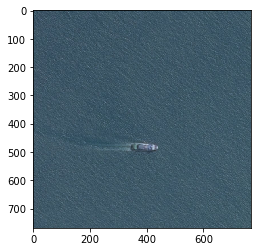

In [12]:
ds = imread(os.path.join(train_dicom_dir, image_fps[0])) # read  image from filepath 
plt.grid(False)
_ = plt.imshow(ds)

In [13]:
# Original image size: 768 x 768
ORIG_SIZE = ds.shape[0]
ORIG_SIZE

768

In [14]:
%%time
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

CPU times: user 3min 46s, sys: 314 ms, total: 3min 46s
Wall time: 3min 46s


In [15]:
%%time
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

CPU times: user 6.56 s, sys: 6.78 ms, total: 6.56 s
Wall time: 6.56 s


(768, 768, 3)
/data1/gaoxi/yh/KaggleShip/DataSet_Kaggle/train_v2/e97ecb93f.jpg
[1]


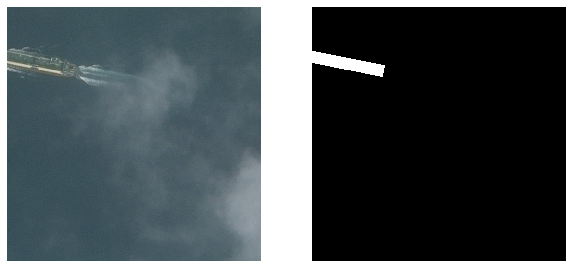

In [16]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_val.image_ids)
    #image_id = 0
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    # image = image.astype(np.float32) - np.array([123.7, 116.8, 103.9])
    # image = mold_image(image, config)
    # print(np.mean(np.mean(image, axis = 0), axis=0))
    # print(image)
    mask, class_ids = dataset_train.load_mask(image_id)  

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += mask[:, :, i] ## * image[:, :, 0]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

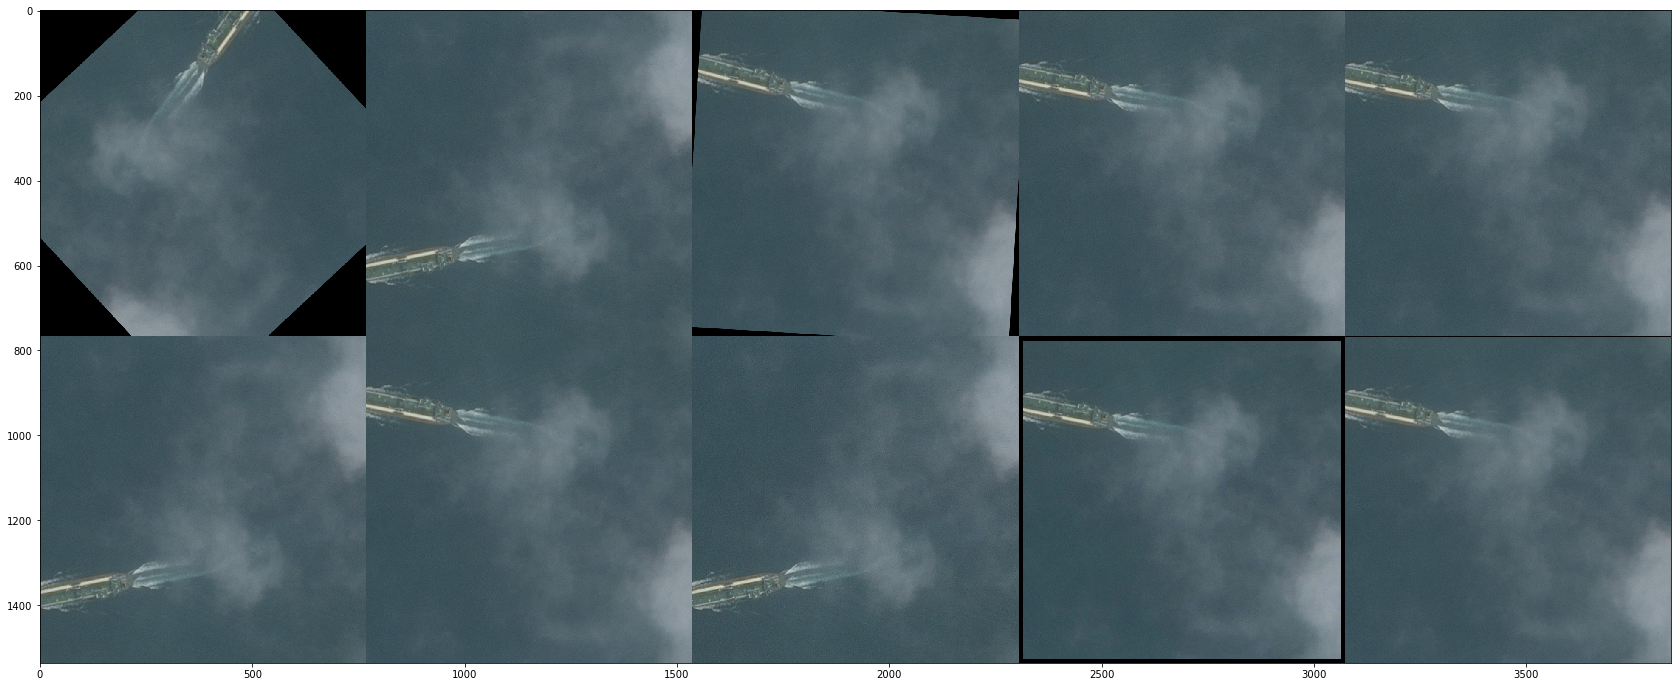

In [17]:
# Image augmentation (light but constant)
# augmentation = iaa.Sometimes(5/6,iaa.OneOf(
#                                             [
#                                             iaa.Fliplr(1), 
#                                             iaa.Flipud(1), 
#                                             iaa.Affine(rotate=(-45, 45)), 
#                                             iaa.Affine(rotate=(-90, 90)), 
#                                             iaa.Affine(scale=(0.9, 1.1))
#                                              ]
#                                         )
#                                    )

augmentation = iaa.SomeOf((1, 3), [
      iaa.Fliplr(0.5),
      iaa.Flipud(0.5),
      iaa.OneOf([iaa.Affine(rotate=(45, -45)),
                 iaa.Affine(rotate=(90, -90))
                 ]),
      iaa.Affine(scale=(0.9, 1.1)),
      iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
      iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
          
     ]),
  ])

# test on the same image as above
imggrid = augmentation.draw_grid(image, cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid.astype(int))

**Now it's time to train the model. Note that training even a basic model can take a few hours.¶**
Note: the following model is for demonstration purpose only. We have limited the training to one epoch, and have set nominal values for the Detector Configuration to reduce run-time.

* dataset_train and dataset_val are derived from DetectorDataset
* DetectorDataset loads images from image filenames and masks from the annotation data
model is Mask-RCNN

In [ ]:
%%time

import tensorflow as tf
# from tensorflow.python import debug as tf_debug
import keras.backend.tensorflow_backend as K

K.clear_session()
config_s = tf.ConfigProto(intra_op_parallelism_threads=24, \
                inter_op_parallelism_threads=24, allow_soft_placement=True, \
                device_count = {'CPU' : 1, 'GPU' : 0})
sess = tf.Session(config=config_s)
# sess = tf_debug.LocalCLIDebugWrapperSession(sess)
# sess.add_tensor_filter("has_inf_or_nan", tf_debug.has_inf_or_nan)

K.set_session(sess)

COCO_WEIGHTS_PATH = './airbus20190821T2149/mask_rcnn_airbus_0015.h5'
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)
# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True)
# LEARNING_RATE = 0.004

# # Train Mask-RCNN Model 

# # Training - Stage 1
# print("Training network TRAIN_ROIS_PER_IMAGE s")
# model.train(dataset_train, dataset_val,
#                 learning_rate=LEARNING_RATE,
#                 epochs=6,
#                 layers='heads',
#                 augmentation=augmentation)

# # Training - Stage 2
# # Finetune layers from ResNet stage 4 and up
# print("Fine tune Resnet stage 4 and up")
# LEARNING_RATE = 0.002
# model.train(dataset_train, dataset_val,
#                 learning_rate=LEARNING_RATE,
#                 epochs=15,
#                 layers='4+',
#                 augmentation=augmentation)
# history = model.keras_model.history.history

# Training - Stage 3
# Fine tune all layers
LEARNING_RATE = 0.0001
print("Fine tune all layers")
model.train(dataset_train, dataset_val,
                 learning_rate=LEARNING_RATE,
                 epochs=10,
                 layers='head',
                 augmentation=augmentation)
history = model.keras_model.history.history

In [ ]:
%%time
# Training - Stage 2
# Finetune layers from ResNet stage 4 and up
print("Fine tune Resnet stage 4 and up")
LEARNING_RATE = 0.002
model.train(dataset_train, dataset_val,
                learning_rate=LEARNING_RATE,
                epochs=15,
                layers='4+',
                augmentation=augmentation)


In [ ]:
%%time
# Training - Stage 3
# Fine tune all layers
print("Fine tune all layers")
LEARNING_RATE = 0.0001
model.train(dataset_train, dataset_val,
                 learning_rate=LEARNING_RATE,
                 epochs=26,
                 layers='all',
                 augmentation=augmentation)
new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

In [ ]:
epochs = range(1, len(history['loss'])+1)
pd.DataFrame(history, index=epochs)

In [ ]:
plt.figure(figsize=(21,11))

plt.subplot(231)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(232)
plt.plot(epochs, history["rpn_class_loss"], label="Train RPN class ce")
plt.plot(epochs, history["val_rpn_class_loss"], label="Valid RPN class ce")
plt.legend()
plt.subplot(233)
plt.plot(epochs, history["rpn_bbox_loss"], label="Train RPN box loss")
plt.plot(epochs, history["val_rpn_bbox_loss"], label="Valid RPN box loss")
plt.legend()
plt.subplot(234)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train MRCNN class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid MRCNN class ce")
plt.legend()
plt.subplot(235)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train MRCNN box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid MRCNN box loss")
plt.legend()
plt.subplot(236)
plt.plot(epochs, history["mrcnn_mask_loss"], label="Train Mask loss")
plt.plot(epochs, history["val_mrcnn_mask_loss"], label="Valid Mask loss")
plt.legend()

plt.show()

In [ ]:
best_epoch = np.argmin(history["val_loss"])
score = history["val_loss"][best_epoch]
print(f'Best Epoch:{best_epoch+1} val_loss:{score}')

In [19]:
# model_path = './airbus20190811T1353/mask_rcnn_airbus_0022_d.h5'

model_path = './airbus20190821T2149/mask_rcnn_airbus_0016.h5'

In [20]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ./airbus20190821T2149/mask_rcnn_airbus_0016.h5
Re-starting from epoch 16


In [21]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

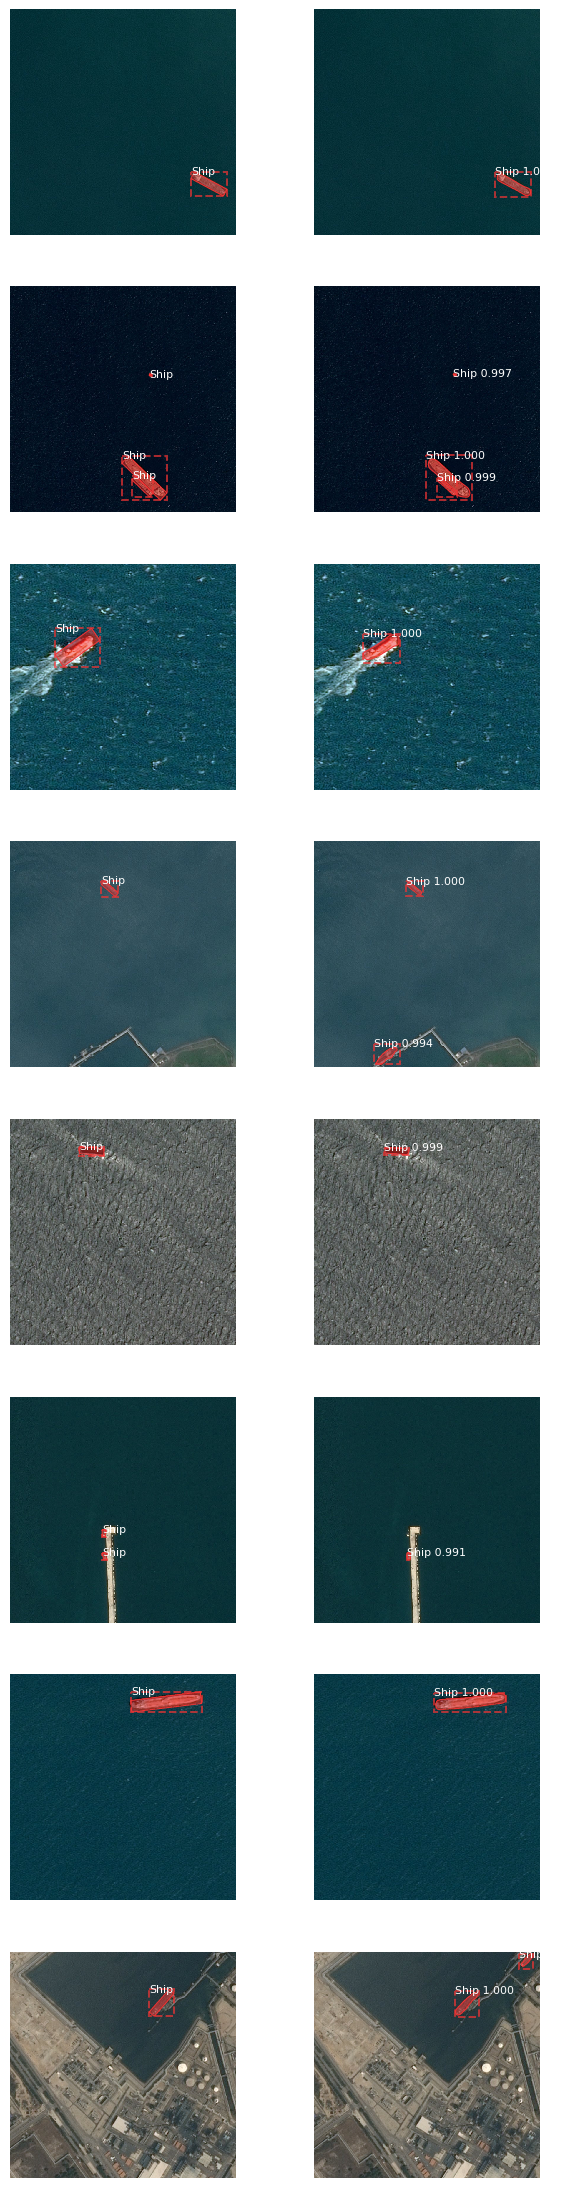

In [31]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 40))

for i in range(8):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
#     print(original_image.shape)
    plt.subplot(8, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1], 
                                call = 'val_gt_%d' % i)
    
    plt.subplot(8, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1], 
                                call = 'val_detect_%d' % i)

In [24]:
# Get filenames of test dataset images
test_image_fps = test_names

In [25]:
DETECTION_TEST_PRED = '/data1/gaoxi/yh/KaggleShip/DataSet_Kaggle/ship_detection.csv'
ship_detection = pd.read_csv(DETECTION_TEST_PRED, index_col='id')
ship_detection.head()

p_ship
id                     
51e9beaca.jpg  0.053764
0a4d97295.jpg  0.412521
c175e03b9.jpg  0.007387
8a56c9bdd.jpg  0.999422
f52f4a484.jpg  0.000480

In [26]:
THRESHOLD = 0.45
test_names_nothing = ship_detection.loc[ship_detection['p_ship'] <= THRESHOLD].index.tolist()
len(test_names_nothing), len(ship_detection), len(test_names_nothing)/len(ship_detection)

(12219, 15606, 0.7829680891964629)

### Predict with TTA

In [ ]:
# use orignal image and flipped Left-Right images
# use arithmetic mean for averaging
TTA = {"augs":["NO",
                "ROT90",
                "ROT270",
                "FLIP_UD",
                "FLIP_LR",
                "CONTRAST"],
         "mean":"ARITH"}

In [ ]:
# Make predictions on test images, write out sample submission

def predict(image_fps, TTA=None, filepath='submission.csv', min_conf=config.DETECTION_MIN_CONFIDENCE):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("ImageId,EncodedPixels\n")

        for image_id in tqdm(image_fps):
            found = False
            
            if image_id not in test_names_nothing:
                image = imread(os.path.join(test_dicom_dir, image_id))
                # If grayscale. Convert to RGB for consistency.
                if len(image.shape) != 3 or image.shape[2] != 3:
                    image = np.stack((image,) * 3, -1)
                
                if not TTA:
                    results = model.detect([image])
                    r = results[0]

                    assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
                    if len(r['rois']) == 0:
                        pass  ## no ship
                    else:
                        num_instances = len(r['rois'])
                        bg = np.zeros((768,768), dtype=np.uint8)

                        for i in range(num_instances):
                            if r['scores'][i] > min_conf:
                                mask = r['masks'][...,i]
                                # Eliminate duplicates in the decoded pixel values
                                mask_xor = (mask^bg)&mask
                                area = mask_xor.sum()
                                if area == 0:
                                    continue
    #                             print(r['scores'][i], r['rois'][i], r['masks'].shape, np.sum(r['masks'][...,i]))
    #                             plt.imshow(r['masks'][...,i], cmap=get_cmap('jet'))
                                file.write(image_id + "," + rle_encode(mask_xor) + "\n")
                                bg += mask_xor
                                found = True
                else:
                    image_fl_LR = cv2.flip(image, 1)
                    image_fl_UD = cv2.flip(image, 0)
                    image_fl_LRUD = cv2.flip(image, -1)
                    
                    results_origin = model.detect([image])
                    results_Fliplr = model.detect()

            if not found:
                file.write(image_id + ",\n")  ## no ship

In [ ]:
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_image_fps, TTA, filepath=submission_fp)
print(submission_fp)

In [28]:
sub = pd.read_csv(submission_fp)
print(sub.EncodedPixels.isnull().sum(), sub.ImageId.nunique(), sub.EncodedPixels.isnull().sum()/sub.ImageId.nunique())
sub.head(50)

12496 15606 0.8007176726899911


ImageId                                      EncodedPixels
0   1652e300c.jpg                                                NaN
1   a918c7e88.jpg                                                NaN
2   68b59b3bd.jpg                                                NaN
3   6d8f436ed.jpg                                                NaN
4   6a733ab11.jpg                                                NaN
5   f041856be.jpg                                                NaN
6   f55ff1b07.jpg                                                NaN
7   e7a804b73.jpg  111614 5 112381 7 113149 7 113917 7 114685 7 1...
8   e7a804b73.jpg  14839 5 15606 6 16374 6 17142 6 17910 7 18678 ...
9   c391d21f5.jpg                                                NaN
10  1eee071a0.jpg                                                NaN
11  92bf43c62.jpg                                                NaN
12  9ee99ce7e.jpg                                                NaN
13  dcf357d31.jpg                                                NaN
14  ab5ce03f5.jpg                                                NaN
15  cee117ce0.jpg                                                NaN
16  5272b32f0.jpg                                                NaN
17  95b417cf4.jpg                                                NaN
18  c2e1d2407.jpg                                                NaN
19  1b93bd1f5.jpg                                                NaN
20  0a045177d.jpg                                                NaN
21  fd9c0bf63.jpg                                                NaN
22  51af52095.jpg                                                NaN
23  2c5531e3e.jpg  532825 6 533590 12 534357 14 535123 17 535890 ...
24  8b3f25e9d.jpg                                                NaN
25  469cd1926.jpg  317559 6 318323 13 319087 19 319851 24 320614 ...
26  d73bd0918.jpg                                                NaN
27  e4bfc6472.jpg  462458 14 463221 20 463986 24 464752 27 465518...
28  e4bfc6472.jpg  128258 6 129025 8 129793 9 130561 9 131329 10 ...
29  a1ea717af.jpg  5165 28 5931 32 6698 34 7465 36 8233 36 9000 3...
30  83d19d128.jpg                                                NaN
31  7e4dc4519.jpg  126587 5 127354 8 128122 9 128890 10 129658 10...
32  86d22ecbb.jpg                                                NaN
33  40372b04c.jpg                                                NaN
34  de9dd30b0.jpg                                                NaN
35  36a2d4f4e.jpg                                                NaN
36  00313b166.jpg                                                NaN
37  d422f16e3.jpg                                                NaN
38  6a4acc2e1.jpg                                                NaN
39  12d2d0de5.jpg  256622 1 257386 13 258152 18 258920 19 259687 ...
40  0d620d4e8.jpg  230115 3 230882 5 231650 6 232417 7 233185 7 2...
41  0d620d4e8.jpg  427475 3 428243 4 429010 5 429778 5 430546 5 4...
42  0d620d4e8.jpg  352469 1 353235 4 354002 5 354769 7 355537 7 3...
43  4a768f17b.jpg                                                NaN
44  48bde3446.jpg                                                NaN
45  bf14188e7.jpg                                                NaN
46  1fcfe352d.jpg                                                NaN
47  af522ba5f.jpg                                                NaN
48  e443ca310.jpg                                                NaN
49  7a1239628.jpg                                                NaN

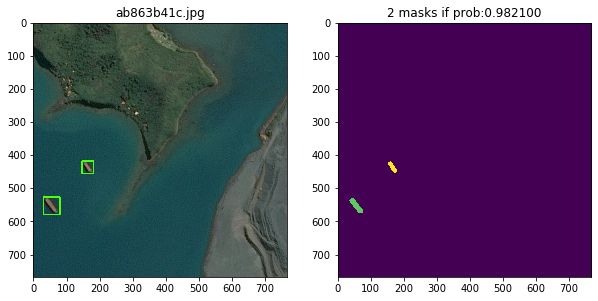

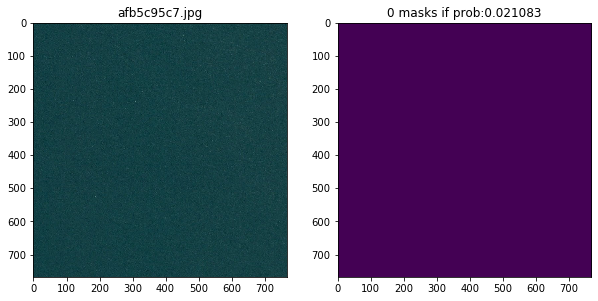

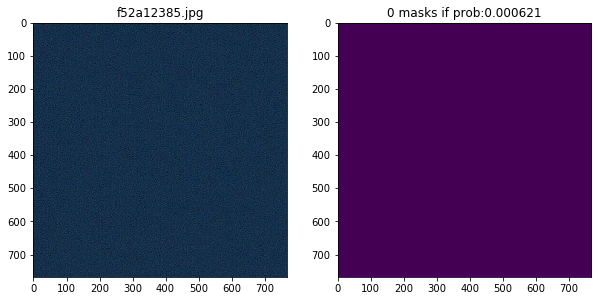

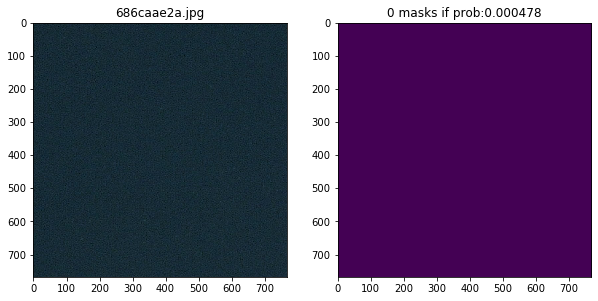

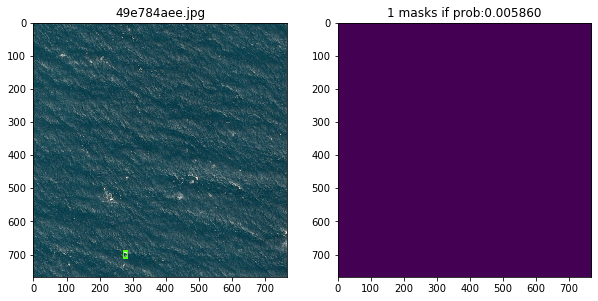

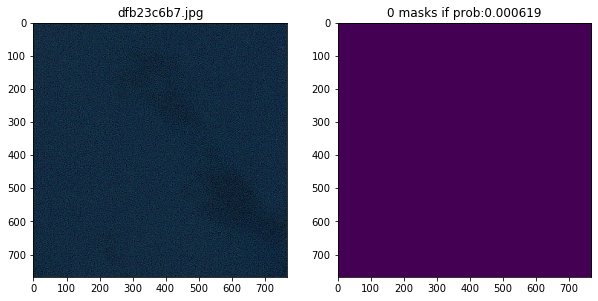

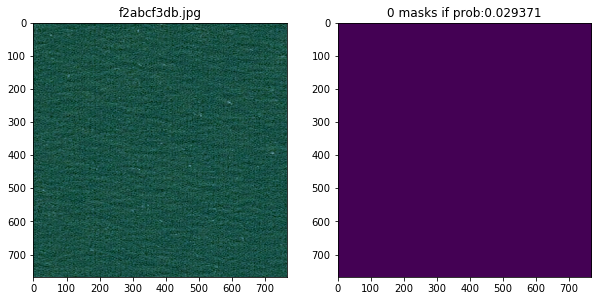

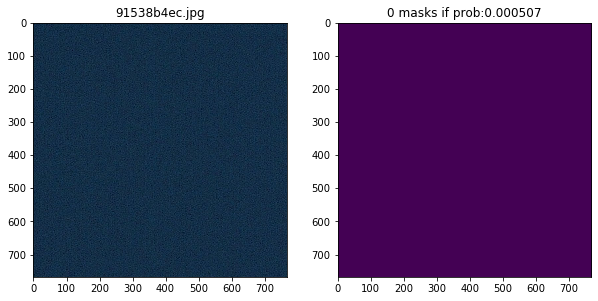

In [32]:
# show a few test image detection example
def visualize_test(): 
    image_id = random.choice(test_names)
    
    # original image
#     print(image_id)
    image = imread(os.path.join(test_dicom_dir, image_id))
    
    # assume square image 
    resize_factor = 1 ## ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
#     image, window, scale, padding, crop = utils.resize_image(
#         image,
#         min_dim=config.IMAGE_MIN_DIM,
#         min_scale=config.IMAGE_MIN_SCALE,
#         max_dim=config.IMAGE_MAX_DIM,
#         mode=config.IMAGE_RESIZE_MODE)

    results = model.detect([image])
    r = results[0]
    for bbox in r['rois']: 
#         print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
#         print("x {} y {} h {} w {}".format(x1, y1, width, height))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_title(f"{image_id}")
    ax1.imshow(image)
    ax2.set_title(f"{len(r['rois'])} masks if prob:{ship_detection.loc[image_id][0]:.6f}")
    ax2.imshow(masks_as_color(sub.query(f"ImageId=='{image_id}'")['EncodedPixels']))
    plt.savefig()
for i in range(8):
    visualize_test()